# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

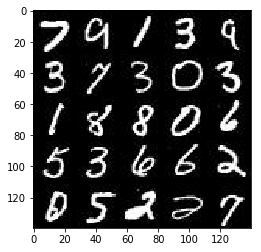

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

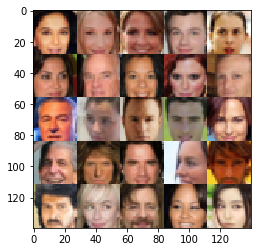

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32,None,name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.02
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        h3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not is_train):

        h1 = tf.layers.dense(z, 7*7*512)
        # Reshape
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        # Output
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """  
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    out_channel_dim = 3
    if (data_image_mode == "L"):
        out_channel_dim = 1
        
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real:batch_images, inputs_z:batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z:batch_z, inputs_real:batch_images})
              
                #print
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real:batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))    
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 9, inputs_z, data_shape[3], data_image_mode)                  
                                                       
        show_generator_output(sess, 9, inputs_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0579... Generator Loss: 3.2535
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 3.3100
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 4.0528
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 1.8155
Epoch 1/2... Discriminator Loss: 1.5668... Generator Loss: 0.3288
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 1.4987
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 1.2280
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 0.5344
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.5159
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 1.4801


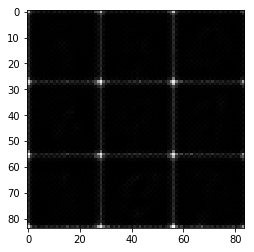

Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 1.9279
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 1.5146
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 1.2192
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.2638
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 0.9907... Generator Loss: 1.7801
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 1.2771
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 1.1793


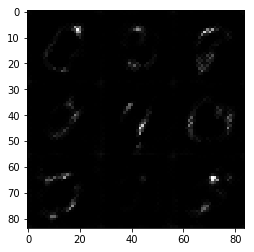

Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 0.8465
Epoch 1/2... Discriminator Loss: 0.8528... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 1.0202
Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 1.5503
Epoch 1/2... Discriminator Loss: 0.9235... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.1463
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.4103


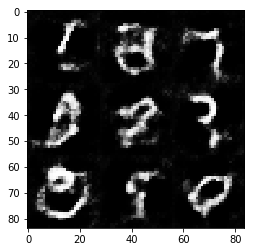

Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.2258
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 2.2004
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 0.9502
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 1.8620
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 1.0973


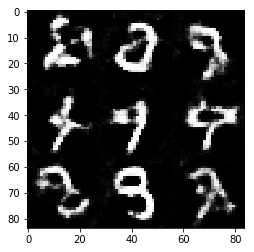

Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.4598
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 0.9155
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 1.9316
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 0.4375
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 0.6664
Epoch 2/2... Discriminator Loss: 1.5110... Generator Loss: 0.3351
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.5783
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.4278


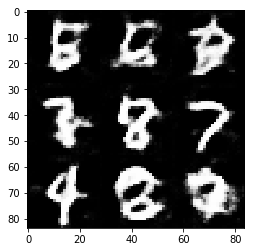

Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.6063
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 2.1206
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 1.1665
Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 1.6395
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 1.5253
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 0.8638


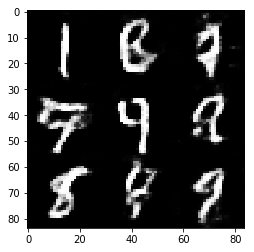

Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.4013
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.5874
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 1.4435
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.3733
Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 2.1403
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.4966
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 0.9538... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 0.4498


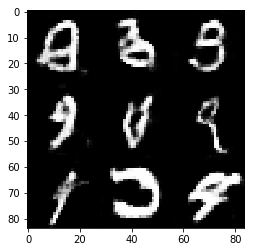

Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.6013
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.3990
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 1.5784
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.7446
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 0.8544
Epoch 2/2... Discriminator Loss: 0.7787... Generator Loss: 1.9522
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.4314
Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 0.8929


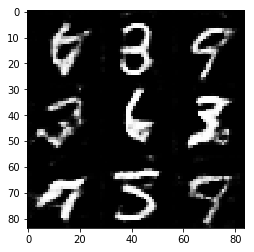

Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.3867
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.3173
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 2.4183
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 0.8267... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 1.4251... Generator Loss: 1.9906
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 0.8465
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 1.0827


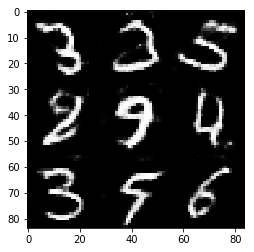

Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 0.8073


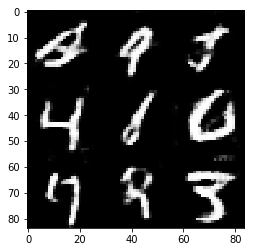

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 1.8816
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.8117
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.3128... Generator Loss: 2.5777
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 1.8246
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 3.2643
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 3.6065
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 2.1760
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 1.2159


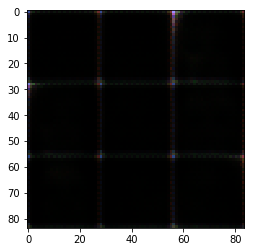

Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 3.7876
Epoch 1/1... Discriminator Loss: 0.1657... Generator Loss: 2.7522
Epoch 1/1... Discriminator Loss: 0.1501... Generator Loss: 3.9395
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 7.7033
Epoch 1/1... Discriminator Loss: 0.3114... Generator Loss: 2.1033
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.9228
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 3.9083
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 2.1786
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.1865


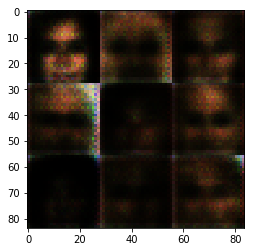

Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 1.8423
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 0.2826... Generator Loss: 3.0017
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 1.8029
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 2.1201
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 2.7357
Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 1.9422
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.4635
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 2.4065... Generator Loss: 2.9761


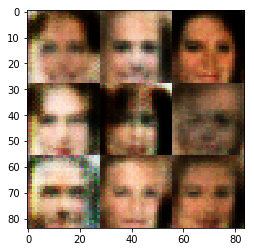

Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 1.6461
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 3.5698
Epoch 1/1... Discriminator Loss: 2.3048... Generator Loss: 3.5148
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.7776... Generator Loss: 0.2579
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.5639


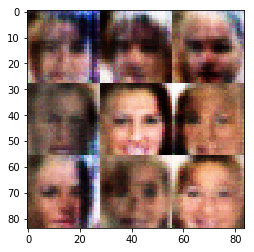

Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.8982
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 1.8725


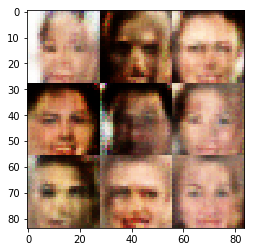

Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 2.5703
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 2.7428
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 1.9255
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 1.0743


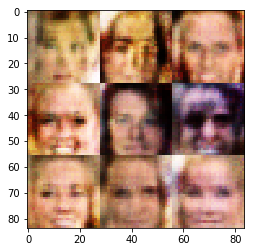

Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.5432


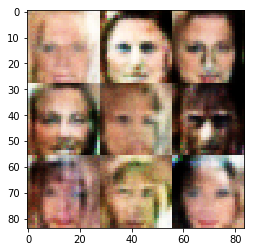

Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 2.1498
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 4.1800
Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 0.2654
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.2874
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 2.2829
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.9720
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 2.0135
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.4168


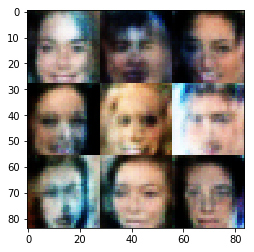

Epoch 1/1... Discriminator Loss: 2.0079... Generator Loss: 0.1801
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 1.9007
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 2.3842... Generator Loss: 0.1185
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.4996
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 2.0120... Generator Loss: 0.1852


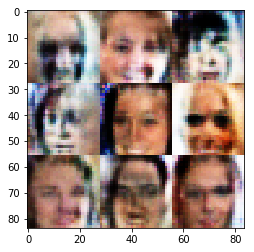

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 1.4464
Epoch 1/1... Discriminator Loss: 1.7417... Generator Loss: 1.5899
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 0.7448... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.0275


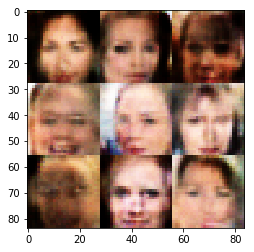

Epoch 1/1... Discriminator Loss: 0.2546... Generator Loss: 2.6956
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 5.5129
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.7074
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 0.9316


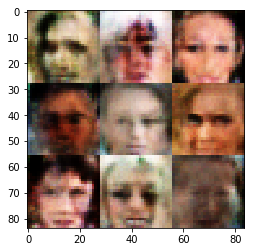

Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 2.1157
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 2.1627
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 3.3922... Generator Loss: 3.8778
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.6719... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 3.2040
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.3035
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.5745


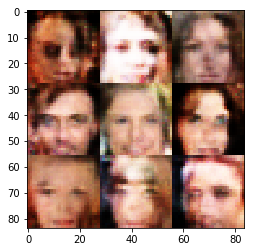

Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 1.9866
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 1.7287
Epoch 1/1... Discriminator Loss: 1.7737... Generator Loss: 0.2417


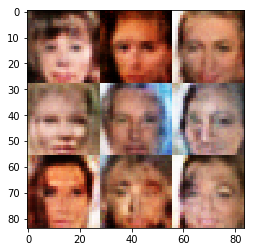

Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.7305
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 1.9858
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 4.3528
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 2.0784
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.5414


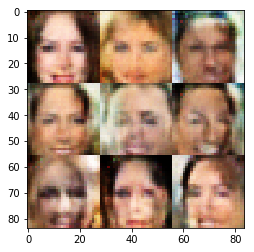

Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 1.8959
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 2.3606
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.5474


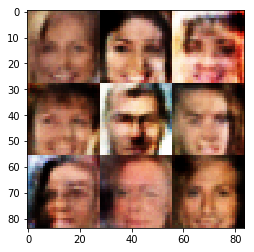

Epoch 1/1... Discriminator Loss: 2.4521... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.7340


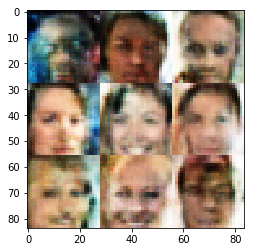

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.